In [1]:
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
import h5py
import json
import zlib
import re
import xml.etree.ElementTree as ET
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border

In [2]:
def walk_h5(f):
    """Print group/dataset names + shapes/dtypes (limited)."""
    def _rec(name, obj):
        if isinstance(obj, h5py.Dataset):
            shape = obj.shape
            dtype = obj.dtype
            print(f"[DSET] {name}  shape={shape}  dtype={dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"[GRP ] {name}")
    f.visititems(_rec)

def read_dataset(f, path):
    dset = f[path]
    arr = dset[()]  # read fully
    return arr

def show_compound_fields(arr, max_fields=50):
    if arr.dtype.names:
        print("Compound fields:")
        for n in arr.dtype.names[:max_fields]:
            print(" ", n)
    else:
        print("Not a compound dataset.")

In [3]:
emd_path = 'Please_download_data_from_our_databank_repository'
with h5py.File(emd_path, "r") as f:
    walk_h5(f)

[GRP ] Application
[GRP ] Application/Velox
[DSET] Application/Velox/DisplayLayout  shape=(1,)  dtype=object
[GRP ] Data
[GRP ] Data/Image
[GRP ] Data/Image/6149a69cd33d4ddb8d73f25e3bf288fc
[DSET] Data/Image/6149a69cd33d4ddb8d73f25e3bf288fc/Data  shape=(2048, 2048, 238)  dtype=uint16
[DSET] Data/Image/6149a69cd33d4ddb8d73f25e3bf288fc/FrameLookupTable  shape=(238,)  dtype=uint32
[DSET] Data/Image/6149a69cd33d4ddb8d73f25e3bf288fc/Metadata  shape=(60000, 238)  dtype=uint8
[GRP ] Data/Text
[DSET] Data/Text/f10ad6f6e7124d5e9904c9424dc57291  shape=(1,)  dtype=object
[DSET] Experiment  shape=(1,)  dtype=object
[GRP ] Features
[DSET] Features/Features  shape=(1,)  dtype=object
[GRP ] Features/STEMFeature
[DSET] Features/STEMFeature/df4dc18620af4dc0915e3d618848dd54  shape=(1,)  dtype=object
[DSET] Info  shape=(1,)  dtype=object
[GRP ] Operations
[GRP ] Operations/DisplayLevelsOperation
[DSET] Operations/DisplayLevelsOperation/8193871f740c4ffbb43e5891acd200c2  shape=(1,)  dtype=object
[DSET] Ope

In [4]:
#Read img_uuid from the last cell
img_uuid = "6149a69cd33d4ddb8d73f25e3bf288fc" #This string is different for each dataset
META_PATH = f"Data/Image/{img_uuid}/Metadata"

def decode_velox_blob(meta_uint8_col):
    b = meta_uint8_col.tobytes()
    b = b.rstrip(b"\x00")

    # zlib-compressed?
    if len(b) >= 2 and b[0] == 0x78 and b[1] in (0x01, 0x5E, 0x9C, 0xDA):
        try:
            b = zlib.decompress(b)
        except Exception:
            pass

    return b.decode("utf-8", errors="replace")

with h5py.File(emd_path, "r") as f:
    meta = f[META_PATH]  # shape (60000, nframes)

    frame = 100   # try also frame = 1, 10, etc.
    txt = decode_velox_blob(meta[:, frame])

print("========== RAW METADATA TEXT (FRAME 0) ==========")
print(txt)
print("========== END METADATA ==========")

========== RAW METADATA TEXT (FRAME 0) ==========
{"Core":{"MetadataDefinitionVersion":"7.9","MetadataSchemaVersion":"v1\/2013\/07","guid":"00000000000000000000000000000000","UserId":"keithjc2"},"Instrument":{"ControlSoftwareVersion":"2.14.1","Manufacturer":"FEI Company","InstrumentId":"9955310","InstrumentClass":"Talos","InstrumentModel":"Talos F200X","ComputerName":"TALOSF-9955310"},"Acquisition":{"AcquisitionStartDatetime":{"DateTime":"1763335432"},"AcquisitionDatetime":{"DateTime":"0"},"BeamType":"","SourceType":"XFEG"},"Optics":{"GunLensSetting":"7","ExtractorVoltage":"3800","AccelerationVoltage":"80000","SpotIndex":"6","C1LensIntensity":"0.19845347748945463","C2LensIntensity":"0.52648682107624123","ObjectiveLensIntensity":"0.79749966087827395","IntermediateLensIntensity":"-0.078506767612941272","DiffractionLensIntensity":"0.39700503388746339","Projector1LensIntensity":"-0.9514665411318749","Projector2LensIntensity":"-0.92141130271692429","LorentzLensIntensity":"0","MiniCondenserL

In [5]:
META_PATH = f"Data/Image/{img_uuid}/Metadata"  # (60000, nframes) uint8

def decode_velox_blob(meta_uint8_col: np.ndarray) -> str:
    b = meta_uint8_col.tobytes().rstrip(b"\x00")

    # Some Velox frames are zlib-compressed
    if len(b) >= 2 and b[0] == 0x78 and b[1] in (0x01, 0x5E, 0x9C, 0xDA):
        try:
            b = zlib.decompress(b)
        except Exception:
            pass

    return b.decode("utf-8", errors="strict")  # strict helps catch silent corruption

with h5py.File(emd_path, "r") as f:
    meta = f[META_PATH]
    nframes = meta.shape[1]

    stage_x = np.full(nframes, np.nan, dtype=float)
    stage_y = np.full(nframes, np.nan, dtype=float)
    tilt_alpha = np.full(nframes, np.nan, dtype=float)

    for j in range(nframes):
        txt = decode_velox_blob(meta[:, j])

        # Some frames may contain leading junk; strip whitespace just in case
        txt = txt.strip()

        try:
            d = json.loads(txt)
            st = d["Stage"]
            pos = st["Position"]

            stage_x[j] = float(pos["x"])
            stage_y[j] = float(pos["y"])
            tilt_alpha[j] = float(st["AlphaTilt"])  # Velox name from your snippet

            if j==0:
                sc = d["Scan"]
                frame_time = float(sc['FrameTime'])

        except Exception as e:
            # Keep NaNs for frames that fail; optionally print the first few failures
            # print(f"Frame {j} failed: {e}")
            pass

print("NaNs:", np.isnan(stage_x).sum(), np.isnan(stage_y).sum(), np.isnan(tilt_alpha).sum())
print("Example:", stage_x[:25], stage_y[:25], tilt_alpha[:25])
print("Frame time:", frame_time)

NaNs: 0 0 0
Example: [0.00058819 0.00058819 0.0005882  0.0005882  0.0005882  0.0005882
 0.0005882  0.00058819 0.0005882  0.0005882  0.00058819 0.0005882
 0.0005882  0.0005882  0.00058819 0.00058819 0.00058819 0.00058819
 0.00058819 0.00058819 0.00058819 0.00058819 0.00058819 0.00058819
 0.00058819] [-0.00017732 -0.00017732 -0.00017732 -0.00017732 -0.00017732 -0.00017732
 -0.00017732 -0.00017733 -0.00017735 -0.00017735 -0.00017737 -0.00017736
 -0.00017737 -0.00017737 -0.00017736 -0.00017737 -0.00017737 -0.00017737
 -0.00017736 -0.00017737 -0.00017737 -0.00017737 -0.00017736 -0.00017736
 -0.00017736] [-1.04721679 -1.04721679 -1.04721679 -1.04721679 -1.04719976 -1.04721679
 -1.04721679 -1.00591786 -1.00357568 -1.00357568 -0.99983672 -0.95994309
 -0.95994309 -0.95994309 -0.91653195 -0.9163105  -0.9163105  -0.9163105
 -0.87266088 -0.87266088 -0.87266088 -0.86701411 -0.82905384 -0.82905384
 -0.82905384]
Frame time: 1.0166904


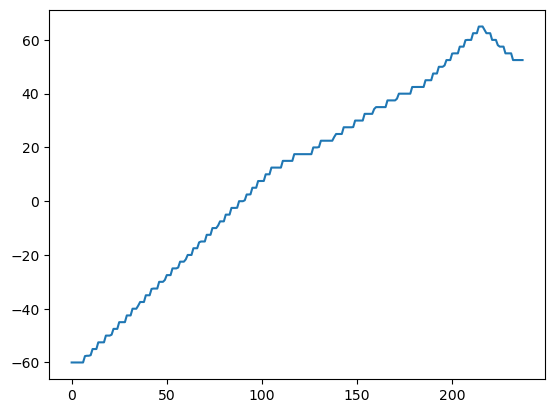

In [7]:
plt.plot(tilt_alpha/np.pi*180)

In [8]:
data = hs.load(emd_path)

In [9]:
def plateaus_from_known_grid(
    tilt_rad,
    step_deg=2.5,
    tol_deg=0.4,      # accept frames within this distance of a target plateau
    min_len=3,        # minimum contiguous length to count as a plateau
):
    """
    Map tilt values onto a known plateau grid and extract contiguous plateau segments.
    Handles repeated plateau values (e.g., reverse scan) by returning multiple segments.
    """
    tilt_deg = np.rad2deg(np.asarray(tilt_rad, dtype=float))

    # Build expected targets from max down to min (inclusive with buffer)
    tmax = np.nanmax(tilt_deg)
    tmin = np.nanmin(tilt_deg)

    # Snap endpoints to the grid so you get clean target values
    # (optional but usually helpful)
    tmax_g = step_deg * np.round(tmax / step_deg)
    tmin_g = step_deg * np.round(tmin / step_deg)

    targets = np.arange(tmax_g, tmin_g - 1e-12, -step_deg)  # descending

    # Assign each frame to nearest target
    # dist: (Nframes, Ntargets)
    dist = np.abs(tilt_deg[:, None] - targets[None, :])
    nearest = np.argmin(dist, axis=1)
    nearest_dist = dist[np.arange(dist.shape[0]), nearest]

    # Valid plateau frames are those close enough to a target
    valid = nearest_dist <= tol_deg

    # Create a label array: target index if valid, else -1 (climb/transition)
    lab = np.full_like(nearest, fill_value=-1, dtype=int)
    lab[valid] = nearest[valid]

    # Extract contiguous runs where lab is constant and != -1
    change = np.flatnonzero(lab[1:] != lab[:-1]) + 1
    starts = np.r_[0, change]
    ends   = np.r_[change, lab.size]

    seg_start = []
    seg_end = []
    seg_target_idx = []
    seg_value_deg = []
    seg_len = []

    for a, b in zip(starts, ends):
        k = lab[a]
        L = b - a
        if k == -1:
            continue
        if L < min_len:
            continue

        seg_start.append(int(a))
        seg_end.append(int(b))
        seg_target_idx.append(int(k))
        seg_value_deg.append(float(targets[k]))
        seg_len.append(int(L))

    return {
        "tilt_deg": tilt_deg,
        "targets_deg": targets,
        "labels": lab,  # -1 for climbs, else index into targets_deg
        "start": np.array(seg_start, dtype=int),
        "end": np.array(seg_end, dtype=int),
        "value_deg": np.array(seg_value_deg, dtype=float),
        "target_idx": np.array(seg_target_idx, dtype=int),
        "length": np.array(seg_len, dtype=int),
    }

In [10]:
plateaus = plateaus_from_known_grid(tilt_alpha, min_len=1)

plateau_vals   = plateaus["value_deg"]   # one value per plateau
plateau_starts = plateaus["start"]
plateau_ends   = plateaus["end"]

print("num plateaus:", len(plateau_vals))
print("first few plateau values:", plateau_vals[:10])
print("first few ranges:", list(zip(plateau_starts[:5], plateau_ends[:5])))

num plateaus: 56
first few plateau values: [-60.  -57.5 -55.  -52.5 -50.  -47.5 -45.  -42.5 -40.  -37.5]
first few ranges: [(np.int64(0), np.int64(7)), (np.int64(7), np.int64(11)), (np.int64(11), np.int64(14)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(22))]


In [11]:
plateau_vals #These are the tilt angles

array([-60. , -57.5, -55. , -52.5, -50. , -47.5, -45. , -42.5, -40. ,
       -37.5, -35. , -32.5, -30. , -27.5, -25. , -22.5, -20. , -17.5,
       -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,
         7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  27.5,
        30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,
        52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  62.5,  60. ,  57.5,
        55. ,  52.5])

In [12]:
def _as_float_image(img):
    img = np.asarray(img)
    if img.dtype.kind in "ui":
        return img.astype(np.float32)
    return img.astype(np.float32, copy=False)

def ptc_norm(I, ptc):
    """
    Percentile-based normalization.

    Parameters
    ----------
    I : array-like
        Input image / array.
    ptc : float
        Percentile (0–100). Uses (100 - ptc) percentile as upper bound.

    Returns
    -------
    I_norm : ndarray
        Normalized array.
    """
    I = np.asarray(I, dtype=np.float32)

    # MATLAB code sets MI = 0 explicitly
    MI = np.percentile(I, 100.0 - ptc[1])

    # Equivalent of prctile(I(:), 100-ptc)
    MA = np.percentile(I, 100.0 - ptc[0])

    return (I - MI) / (MA - MI)

# def ncc_score(a, b, eps=1e-12):
#     """
#     Normalized cross-correlation scalar score in [-1, 1].
#     Higher => more similar.
#     """
#     a = _as_float_image(a)
#     b = _as_float_image(b)

#     a = a - a.mean()
#     b = b - b.mean()

#     denom = (np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())) + eps
#     return float((a*b).sum() / denom)

# def phase_correlation_shift(ref, mov, eps=1e-12):
#     """
#     Phase correlation to estimate integer pixel shift (dy, dx) that aligns mov to ref.

#     Returns
#     -------
#     shift : (dy, dx) integers
#         Apply this shift to mov to align it to ref.
#     peak : float
#         Peak magnitude of correlation surface (rough quality indicator).
#     """
#     ref = _as_float_image(ref)
#     mov = _as_float_image(mov)

#     F = np.fft.fft2(ref)
#     G = np.fft.fft2(mov)

#     R = F * np.conj(G)
#     R /= (np.abs(R) + eps)

#     cc = np.fft.ifft2(R)
#     cc_abs = np.abs(cc)

#     peak = float(cc_abs.max())
#     maxpos = np.unravel_index(np.argmax(cc_abs), cc_abs.shape)
#     dy, dx = maxpos

#     # wrap to signed shifts
#     h, w = ref.shape
#     if dy > h // 2:
#         dy -= h
#     if dx > w // 2:
#         dx -= w

#     return (int(dy), int(dx)), peak

def _binary_largest_cc_com(mask):
    """
    Find COM (y, x) of the largest connected component in a binary mask.
    Uses 8-connectivity. Pure numpy (no scipy).
    Returns None if no foreground.
    """
    mask = np.asarray(mask, dtype=bool)
    h, w = mask.shape
    if mask.sum() == 0:
        return None

    visited = np.zeros_like(mask, dtype=bool)

    best_area = 0
    best_sumy = 0.0
    best_sumx = 0.0

    # Neighbor offsets for 8-connectivity
    nbrs = [(-1, -1), (-1, 0), (-1, 1),
            ( 0, -1),          ( 0, 1),
            ( 1, -1), ( 1, 0), ( 1, 1)]

    ys, xs = np.where(mask)
    for y0, x0 in zip(ys, xs):
        if visited[y0, x0]:
            continue

        # BFS/stack
        stack = [(int(y0), int(x0))]
        visited[y0, x0] = True

        area = 0
        sumy = 0.0
        sumx = 0.0

        while stack:
            y, x = stack.pop()
            area += 1
            sumy += y
            sumx += x

            for dy, dx in nbrs:
                yy = y + dy
                xx = x + dx
                if 0 <= yy < h and 0 <= xx < w and mask[yy, xx] and (not visited[yy, xx]):
                    visited[yy, xx] = True
                    stack.append((yy, xx))

        if area > best_area:
            best_area = area
            best_sumy = sumy
            best_sumx = sumx

    return (best_sumy / best_area, best_sumx / best_area)


def _com_of_largest_region(img, *, thresh="otsu", invert=False, min_area=1):
    """
    Compute COM of the largest region after binarization.
    Falls back to intensity-weighted COM if no region is found.
    """
    img = np.asarray(img, dtype=np.float32)

    if thresh == "otsu":
        t = threshold_otsu(img)
    elif isinstance(thresh, (int, float)):
        t = float(thresh)
    else:
        raise ValueError("thresh must be 'otsu' or a numeric threshold")

    mask = img > t
    if invert:
        mask = ~mask

    # Remove tiny masks by area threshold if requested (applied after labeling via best_area)
    com = _binary_largest_cc_com(mask)
    if com is None:
        # Fallback: intensity-weighted COM
        x = np.clip(img - np.nanmin(img), 0, None)
        s = float(np.sum(x))
        if s <= 1e-12:
            # final fallback: geometric center
            h, w = img.shape
            return (h / 2.0, w / 2.0)
        yy, xx = np.indices(img.shape, dtype=np.float32)
        return (float(np.sum(yy * x) / s), float(np.sum(xx * x) / s))

    return com


def phase_correlation_shift(ref, mov, eps=1e-12):
    """
    Replacement with the SAME I/O as your old phase_correlation_shift:
      returns ((dy, dx), peak)

    Shift is computed from COM of the largest connected region
    in a binarized image (Otsu threshold by default).

    peak = 1/(1+distance) where distance is Euclidean COM distance in pixels.
    """
    ref = np.asarray(ref)
    mov = np.asarray(mov)

    (y_ref, x_ref) = _com_of_largest_region(ref, thresh="otsu", invert=False)
    (y_mov, x_mov) = _com_of_largest_region(mov, thresh="otsu", invert=False)

    dy_f = y_ref - y_mov
    dx_f = x_ref - x_mov

    dy = int(np.round(dy_f))
    dx = int(np.round(dx_f))

    dist = float(np.hypot(dy_f, dx_f))
    peak = 1.0 / (1.0 + dist + eps)  # higher = better alignment confidence

    return (dy, dx), peak

# def com_distance_score(ref_img, cand_img):
#     """Distance between COMs (pixels). Smaller = more similar."""
#     (y1, x1) = _com_of_largest_region(ref_img, thresh="otsu", invert=False)
#     (y2, x2) = _com_of_largest_region(cand_img, thresh="otsu", invert=False)
#     return float(np.hypot(y1 - y2, x1 - x2))

# def shift_with_zeropad(img, dy, dx):
#     """
#     Shift img by (dy, dx) with zero padding (no wraparound).
#     Positive dy shifts DOWN, positive dx shifts RIGHT.
#     """
#     img = np.asarray(img)
#     h, w = img.shape
#     out = np.zeros_like(img)

#     # Source and destination slices
#     if dy >= 0:
#         ys_src = slice(0, h - dy)
#         ys_dst = slice(dy, h)
#     else:
#         ys_src = slice(-dy, h)
#         ys_dst = slice(0, h + dy)

#     if dx >= 0:
#         xs_src = slice(0, w - dx)
#         xs_dst = slice(dx, w)
#     else:
#         xs_src = slice(-dx, w)
#         xs_dst = slice(0, w + dx)

#     out[ys_dst, xs_dst] = img[ys_src, xs_src]
#     return out

# def select_one_per_plateau_and_register(data, plateau_starts, plateau_ends, *,
#                                         score="min_ncc"):
#     """
#     Parameters
#     ----------
#     data : HyperSpy Signal2D stack
#         data.inav[k].data is a (H,W) image.
#     plateau_starts, plateau_ends : arrays
#         Each plateau i corresponds to frames [start[i], end[i]).
#     score : str
#         Only implemented: "min_ncc" (select candidate with smallest NCC to prev)

#     Returns
#     -------
#     chosen_indices : (K,) int
#         Index of chosen frame per plateau.
#     registered_images : list of 2D np arrays
#         Chosen frames after phase-correlation alignment (frame 0 is unshifted).
#     shifts : list of (dy, dx)
#         Shift applied to each chosen frame (0,0 for first).
#     ncc_values : list of float
#         NCC between prev chosen frame and chosen candidate (before shifting).
#     corr_peaks : list of float
#         Peak value of phase-correlation surface (quality indicator).
#     """
#     starts = np.asarray(plateau_starts, dtype=int)
#     ends   = np.asarray(plateau_ends, dtype=int)
#     K = len(starts)
#     if K == 0:
#         raise ValueError("No plateaus provided.")

#     chosen_indices = np.empty(K, dtype=int)
#     registered_images = []
#     shifts = []
#     ncc_values = []
#     corr_peaks = []

#     # Step 0: choose first frame of first plateau
#     chosen_indices[0] = starts[0]
#     ref = ptc_norm(data.inav[chosen_indices[0]].data, [1, 25])
#     registered_images.append(ref)
#     shifts.append((0, 0))
#     ncc_values.append(np.nan)
#     corr_peaks.append(np.nan)

#     # Steps 1..K-1
#     for i in range(1, K):
#         ref = registered_images[-1]  # previous selected (already registered)

#         cand_idxs = np.arange(starts[i], ends[i], dtype=int)
#         if cand_idxs.size == 0:
#             raise ValueError(f"Plateau {i} is empty: start={starts[i]}, end={ends[i]}")

#         # Compute NCC for each candidate vs ref
#         scores = np.empty(cand_idxs.size, dtype=float)
#         for t, j in enumerate(cand_idxs):
#             img = ptc_norm(data.inav[j].data, [1, 25])
#             scores[t] = com_distance_score(ref, img)
            
#         if score == "min_ncc":
#             pick = int(np.argmin(scores))  # smallest NCC
#         else:
#             raise ValueError("Only score='min_ncc' is implemented.")

#         j_best = int(cand_idxs[pick])
#         img_best = ptc_norm(data.inav[j_best].data, [1, 25])
#         ncc_best = float(scores[pick])

#         # Estimate shift and apply zero-padded shift
#         (dy, dx), peak = phase_correlation_shift(ref, img_best)
#         img_reg = shift_with_zeropad(img_best, dy, dx)

#         chosen_indices[i] = j_best
#         registered_images.append(img_reg)
#         shifts.append((dy, dx))
#         ncc_values.append(ncc_best)
#         corr_peaks.append(peak)

#     return chosen_indices, registered_images, shifts, ncc_values, corr_peaks

def shift_with_zeropad(img, dy, dx):
    """Shift img by (dy, dx) with zero padding (no wraparound)."""
    img = np.asarray(img)
    h, w = img.shape
    out = np.zeros_like(img)

    if dy >= 0:
        ys_src = slice(0, h - dy)
        ys_dst = slice(dy, h)
    else:
        ys_src = slice(-dy, h)
        ys_dst = slice(0, h + dy)

    if dx >= 0:
        xs_src = slice(0, w - dx)
        xs_dst = slice(dx, w)
    else:
        xs_src = slice(-dx, w)
        xs_dst = slice(0, w + dx)

    out[ys_dst, xs_dst] = img[ys_src, xs_src]
    return out


def _binary_mask(img, thresh="otsu", invert=False):
    """Create a binary mask from an image using a fast threshold rule."""
    img = np.asarray(img, dtype=np.float32)

    if thresh == "p99":
        t = np.percentile(img, 99.0)
    elif thresh == "p98":
        t = np.percentile(img, 98.0)
    elif thresh == "otsu":
        t = threshold_otsu(img)
    elif isinstance(thresh, (int, float)):
        t = float(thresh)
    else:
        raise ValueError("thresh must be 'p98'/'p99'/'otsu' or a numeric threshold")

    mask = img > t

    if invert:
        mask = ~mask
        
    # mask = clear_border(mask)

    return mask


def com_largest_region(mask):
    """
    COM (y,x) of the largest connected component in mask.
    Fast path uses scipy.ndimage if available; fallback uses COM of all foreground.
    """
    mask = np.asarray(mask, dtype=bool)
    if mask.sum() == 0:
        return None

    try:
        from scipy import ndimage as ndi

        labeled, nlab = ndi.label(mask)  # 8-connectivity default for 2D
        if nlab == 0:
            return None

        sizes = np.bincount(labeled.ravel())
        sizes[0] = 0  # background
        lab = int(np.argmax(sizes))

        com = ndi.center_of_mass(mask, labeled, lab)  # (y, x)
        return (float(com[0]), float(com[1]))

    except Exception:
        # Fallback (no scipy): COM of all foreground pixels (fast, not largest-region-specific)
        yy, xx = np.nonzero(mask)
        return (float(yy.mean()), float(xx.mean()))


def com_shift(ref_img, mov_img, *, thresh="otsu", invert=False):
    """
    Compute integer shift (dy,dx) that aligns mov_img to ref_img
    using COM of largest binarized region.
    """
    ref_mask = _binary_mask(ref_img, thresh=thresh, invert=invert)
    mov_mask = _binary_mask(mov_img, thresh=thresh, invert=invert)

    com_ref = com_largest_region(ref_mask)
    com_mov = com_largest_region(mov_mask)

    if com_ref is None or com_mov is None:
        return (0, 0)  # nothing detected; no shift

    dy = int(np.round(com_ref[0] - com_mov[0]))
    dx = int(np.round(com_ref[1] - com_mov[1]))
    return (dy, dx)


def register_align(data, step_starts, step_ends, *,
                                     thresh="otsu", invert=False,
                                     frame_offset=-2):
    """
    For each step i, choose frame = step_ends[i] + frame_offset (default: end-2),
    then register it to the previous chosen frame using COM shift + zero padding.

    Returns
    -------
    chosen_idx : (K,) int
    registered_images : list of 2D arrays
    shifts : list of (dy, dx)
    """
    starts = np.asarray(step_starts, dtype=int)
    ends   = np.asarray(step_ends, dtype=int)
    K = len(starts)
    if K == 0:
        raise ValueError("No steps provided.")

    chosen_idx = np.empty(K, dtype=int)
    registered_images = []
    shifts = []

    # Step 0: first frame of step 0
    chosen_idx[0] = int(starts[0])
    ref = ptc_norm(np.asarray(data.inav[chosen_idx[0]].data), [1, 25])
    registered_images.append(ref)
    shifts.append((0, 0))

    # Steps 1..K-1: pick end-2 (or other offset) and register by COM shift
    for i in range(1, K):
        idx = int(ends[i] + frame_offset)
        if idx < starts[i]:
            # if the step is too short, fall back to last frame in step
            idx = int(ends[i] - 1)
        if idx < starts[i] or idx >= ends[i]:
            raise ValueError(f"Bad index for step {i}: start={starts[i]}, end={ends[i]}, idx={idx}")

        chosen_idx[i] = idx
        mov = ptc_norm(np.asarray(data.inav[idx].data), [1, 25])

        ref = registered_images[-1]
        dy, dx = com_shift(ref, mov, thresh=thresh, invert=invert)
        mov_reg = shift_with_zeropad(mov, dy, dx)

        registered_images.append(mov_reg)
        shifts.append((dy, dx))

    return chosen_idx, registered_images, shifts

In [22]:
# cropped = data.isig[512:2048-512, 512:2048-512]

In [13]:
chosen_idx, reg_imgs, shifts = register_align(
    data,
    step_starts=plateaus["start"],
    step_ends=plateaus["end"],
    thresh="otsu",    # fast + robust for bright HAADF features
    invert=True,    # HAADF features usually bright
    frame_offset=-2  # second-to-last
)

print("Chosen indices:", chosen_idx)
print("First 10 shifts:", shifts[:10])
# print("First 10 NCCs:", nccs[:10])

Chosen indices: [  0   9  12  16  20  23  27  30  33  37  40  44  47  51  55  58  62  65
  69  72  75  79  82  86  90  93  96 100 103 109 115 125 129 136 141 147
 152 157 164 169 177 184 188 191 194 198 202 205 209 212 215 219 222 226
 230 236]
First 10 shifts: [(0, 0), (-2, -3), (-6, 8), (-5, 6), (-2, -5), (-6, -4), (2, -5), (-2, -3), (-5, -6), (-3, -6)]


In [ ]:
def split_into_sweeps(vals, *, step=2.5):
    if not vals:
        return [], []

    segs_vals = []
    segs_idx = []

    cur_vals = [vals[0]]
    cur_idx  = [0]

    prev_val = vals[0]
    prev_idx = 0
    direction = 0  # +1, -1, or 0 (unknown)

    for i in range(1, len(vals)):
        x = vals[i]
        d = x - prev_val

        # invalid step → force break
        if d not in (step, -step):
            segs_vals.append(cur_vals)
            segs_idx.append(cur_idx)

            cur_vals = [prev_val, x]
            cur_idx  = [prev_idx, i]
            direction = 0

        else:
            new_dir = 1 if d == step else -1

            if direction == 0:
                direction = new_dir
                cur_vals.append(x)
                cur_idx.append(i)

            elif new_dir == direction:
                cur_vals.append(x)
                cur_idx.append(i)

            else:
                # direction flip → close and start new with shared border
                segs_vals.append(cur_vals)
                segs_idx.append(cur_idx)

                cur_vals = [prev_val, x]
                cur_idx  = [prev_idx, i]
                direction = new_dir

        prev_val = x
        prev_idx = i

    segs_vals.append(cur_vals)
    segs_idx.append(cur_idx)

    return segs_vals, segs_idx

In [14]:
import os
import tifffile as tiff

os.makedirs("output", exist_ok=True)
segs, indices = split_into_sweeps(plateau_vals)

for i, idx in enumerate(indices):
    if len(idx) == 0:
        continue

    # Select frames belonging to this segment
    stack = np.stack([reg_imgs[j] for j in idx], axis=0)

    fname = f"output/{i:03d}.tif"   # 000–999 safe (covers 00–99 too)

    tiff.imwrite(
        fname,
        stack,
        dtype=stack.dtype,
        photometric="minisblack",
        metadata=None,
    )

    print(f"Saved {stack.shape[0]} frames to {fname}") #These are the files ready to be reconstructed

Saved 56 frames to 20251116 1723.tif


In [15]:
def save_frame_tilt_csv_no_header(
    chosen_idx,
    tilt_alpha_rad,
    frame_time,
    out_csv="frame_tilt.csv",
):
    chosen_idx = np.asarray(chosen_idx, dtype=int)
    tilt_alpha_rad = np.asarray(tilt_alpha_rad, dtype=float)

    # Column 1: frame_rate * (1 + chosen_idx[i])
    col1 = frame_time * (1.0 + chosen_idx)

    # Column 2: tilt_alpha in degrees at chosen indices
    col2 = np.rad2deg(tilt_alpha_rad[chosen_idx])

    # Stack into (N, 2)
    data = np.column_stack((col1, col2))

    # Save CSV with no header, no index
    np.savetxt(
        out_csv,
        data,
        delimiter=",",
        fmt="%.1f",
    )

    return data

In [16]:
save_frame_tilt_csv_no_header(
    chosen_idx,
    tilt_alpha,
    frame_time,
    out_csv="timeAngleSeries.csv", #This is the csv file required for alignment and reconstruction
)

array([[ 1.01669040e+00, -6.00011025e+01],
       [ 1.01669040e+01, -5.75006512e+01],
       [ 1.32169752e+01, -5.50006879e+01],
       [ 1.72837368e+01, -5.25007245e+01],
       [ 2.13504984e+01, -4.99997853e+01],
       [ 2.44005696e+01, -4.75012859e+01],
       [ 2.84673312e+01, -4.49998586e+01],
       [ 3.15174024e+01, -4.25018473e+01],
       [ 3.45674736e+01, -3.99999320e+01],
       [ 3.86342352e+01, -3.75024086e+01],
       [ 4.16843064e+01, -3.50000054e+01],
       [ 4.57510680e+01, -3.25005300e+01],
       [ 4.88011392e+01, -3.00000787e+01],
       [ 5.28679008e+01, -2.75006034e+01],
       [ 5.69346624e+01, -2.50001521e+01],
       [ 5.99847336e+01, -2.25011648e+01],
       [ 6.40514952e+01, -2.00007135e+01],
       [ 6.71015664e+01, -1.75027021e+01],
       [ 7.11683280e+01, -1.50012748e+01],
       [ 7.42183992e+01, -1.25057034e+01],
       [ 7.72684704e+01, -1.00013482e+01],
       [ 8.13352320e+01, -7.50577680e+00],
       [ 8.43853032e+01, -5.00044561e+00],
       [ 8.

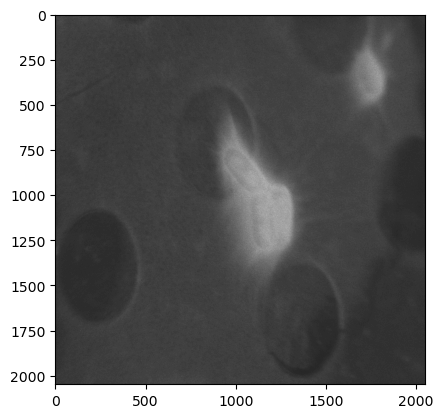

In [46]:
plt.imshow(ptc_norm(data.data[0], [25,1]), cmap='gray')